### Bibliotecas

In [2]:
import pandas as pd
import numpy as np
import pywt
import timeit
from datetime import timedelta
from tqdm import tqdm

from scipy.stats import norm, linregress
from scipy.fftpack import fft
from scipy import signal

from aeon.datasets.tsc_data_lists import univariate_equal_length
from aeon.datasets import load_classification
from aeon.classification.distance_based import KNeighborsTimeSeriesClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifierCV

import warnings
warnings.filterwarnings("ignore")

In [19]:
dataset_list = ['Adiac', 'Beef', 'Car', 'CBF', 'Coffee', 'DiatomSizeReduction', 'ECG200', 'ECGFiveDays', 'FaceFour',
'GunPoint', 'Lightning2', 'Lightning7', 'MedicalImages', 'MoteStrain', 'OliveOil', 'SonyAIBORobotSurface1', 'SyntheticControl', 'Trace', 'TwoPatterns']
#SonyAIBORobotSurface2
# Para cada conjunto de dados na lista
total_time = 0
for dataset_name in dataset_list:
    # Carregue os dados de treinamento e teste
    X_train, y_train = load_classification(dataset_name, extract_path="./Temp/", split="TRAIN")
    X_test, y_test = load_classification(dataset_name, extract_path="./Temp/", split="test")
    
    # Achatando os dados para 2D, pois alguns algoritmos esperam 2D
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    
    dataset_accuracies = []
    # Para cada algoritmo
    
    # Treinar o modelo e fazer previsões
    start = timeit.default_timer()
    trained_base_models, meta_classifier = train_with_meta_classifier(X_train_flat, y_train, base_option='svm', meta_option='svm')
    predictions_test_meta = predict_with_meta_classifier(X_test_flat, trained_base_models, meta_classifier)
    stop = timeit.default_timer()
    total_time += stop - start
    real_time = str(timedelta(seconds=total_time))

    # Calcular a acurácia e armazená-la
    test_accuracy_meta = np.mean(predictions_test_meta == y_test)
    dataset_accuracies.append(test_accuracy_meta)


    print(f"Acurácia do modelo SVM para {dataset_name}: {test_accuracy_meta}")
    print('Time runtime (seconds): ', real_time)
        
np.savetxt("Results_1NN_.csv", dataset_accuracies, delimiter=",")

Testing Instances: 100%|##########| 391/391 [00:02<00:00, 168.82it/s]


Acurácia do modelo SVM para Adiac: 0.8337595907928389
Time runtime (seconds):  0:00:37.228216


Testing Instances: 100%|##########| 30/30 [00:00<00:00, 150.08it/s]


Acurácia do modelo SVM para Beef: 0.9
Time runtime (seconds):  0:00:37.744201


Testing Instances: 100%|##########| 60/60 [00:00<00:00, 128.53it/s]


Acurácia do modelo SVM para Car: 0.8166666666666667
Time runtime (seconds):  0:00:38.640012


Testing Instances: 100%|##########| 900/900 [00:03<00:00, 284.20it/s]


Acurácia do modelo SVM para CBF: 0.8877777777777778
Time runtime (seconds):  0:00:41.943012


Testing Instances: 100%|##########| 28/28 [00:00<00:00, 168.01it/s]


Acurácia do modelo SVM para Coffee: 1.0
Time runtime (seconds):  0:00:42.309397


Testing Instances: 100%|##########| 306/306 [00:01<00:00, 178.33it/s]


Acurácia do modelo SVM para DiatomSizeReduction: 0.9771241830065359
Time runtime (seconds):  0:00:44.122892


Testing Instances: 100%|##########| 100/100 [00:00<00:00, 315.91it/s]


Acurácia do modelo SVM para ECG200: 0.84
Time runtime (seconds):  0:00:45.134061


Testing Instances: 100%|##########| 861/861 [00:03<00:00, 279.63it/s]


Acurácia do modelo SVM para ECGFiveDays: 0.9976771196283392
Time runtime (seconds):  0:00:48.303343


Testing Instances: 100%|##########| 88/88 [00:00<00:00, 170.42it/s]


Acurácia do modelo SVM para FaceFour: 0.875
Time runtime (seconds):  0:00:48.945147


Testing Instances: 100%|##########| 150/150 [00:00<00:00, 271.76it/s]


Acurácia do modelo SVM para GunPoint: 0.92
Time runtime (seconds):  0:00:50.269176


Testing Instances: 100%|##########| 61/61 [00:00<00:00, 122.70it/s]


Acurácia do modelo SVM para Lightning2: 0.6885245901639344
Time runtime (seconds):  0:00:55.568443


Testing Instances: 100%|##########| 73/73 [00:00<00:00, 184.57it/s]


Acurácia do modelo SVM para Lightning7: 0.684931506849315
Time runtime (seconds):  0:00:56.288423


Training Base Models:  36%|###5      | 5/14 [01:06<01:16,  8.51s/it]

### Input e Div do Train/Test com arquivos locais no formato parquet

In [3]:
try:
    train_data = pd.read_parquet('MSC\CSV_Dissertação\Parquet_Dissertacao\Adiac_TRAIN.parquet')
    test_data = pd.read_parquet('MSC\CSV_Dissertação\Parquet_Dissertacao\Adiac_TEST.parquet')
except FileNotFoundError:
    print("Ensure the Parquet files are in the correct path.")
    raise

In [4]:
X_train = train_data.drop('target', axis=1).values
y_train = train_data['target'].values

X_test = test_data.drop('target', axis=1).values
y_test = test_data['target'].values

### Classe Data Analyzer

In [18]:
class DataAnalyzer:
    def __init__(self, data):
        self.data = data
        self.sample_size, self.series_size = data.shape
        self.mean = None
        self.fft = np.array([])
        self.slope = np.array([])
        self.intercept = np.array([])
        self.detrend = np.array([])
        self.adjusted_fft_windowed = np.array([])
        self.max = np.array([])
        self.min = np.array([])
        self.laplace = None
        #self.fft_pca = PCA()
        #self.adj_fft_pca = PCA()
        self.arc = np.array([])
        self.elastic_net = np.array([])
        #self.pca = PCA()
        #self.pca_arc = PCA()
        self.classes = None

    def get_fft(self):
        if self.fft.size == 0:
            self.fft = fft(self.data)
        return self.fft

    def get_mean(self, axis=1):
        if self.mean is None:
            self.mean = np.mean(self.data, axis=axis)
        return self.mean

    def get_slope(self):
        if self.slope.size == 0:
            intercepts = np.zeros(self.sample_size)
            slopes = np.zeros(self.sample_size)
            rvals = np.zeros(self.sample_size)
            pvals = np.zeros(self.sample_size)
            stderrs = np.zeros(self.sample_size)
            for idx, row in zip(range(self.sample_size), self.data):
                s, i, r, p, st = linregress(range(self.series_size), row)
                intercepts[idx] = i
                slopes[idx] = s
                rvals[idx] = r
                pvals[idx] = p
                stderrs[idx] = st
            self.intercept = intercepts
            self.slope = slopes
            self.rvalues = rvals
            self.pvalues = pvals
            self.stderrors = stderrs
        return self.slope

    def get_intercept(self):
        if self.intercept.size == 0:
            intercepts = np.zeros(self.sample_size)
            slopes = np.zeros(self.sample_size)
            rvals = np.zeros(self.sample_size)
            pvals = np.zeros(self.sample_size)
            stderrs = np.zeros(self.sample_size)
            for idx, row in zip(range(self.sample_size), self.data):
                s, i, r, p, st = linregress(range(self.series_size), row)
                intercepts[idx] = i.real  # Apenas a parte real do intercepto
                slopes[idx] = s
                rvals[idx] = r
                pvals[idx] = p
                stderrs[idx] = st
            self.intercept = intercepts
            self.slope = slopes
            self.rvalues = rvals
            self.pvalues = pvals
            self.stderrors = stderrs
        return self.intercept

    def get_detrend(self):
        if self.detrend.size == 0:
            linout = self.data - (np.repeat(np.arange(self.series_size), self.sample_size).reshape([self.sample_size, self.series_size]).T \
                                  * self.get_slope()).T - np.repeat(self.get_intercept(), self.series_size).reshape(
                [self.series_size, self.sample_size]).T
            self.detrend = linout / self.get_mean()[:, None]
        return self.detrend

    def get_adjusted_fft_windowed(self):
        if self.adjusted_fft_windowed.size == 0:
            detrended_data = self.get_detrend()
            window = signal.windows.blackman(self.series_size)
            windowed_data = detrended_data * window
            fft_result = fft(windowed_data)
            self.adjusted_fft_windowed = np.abs(fft_result)  # Pegando o módulo dos valores complexos
        return self.adjusted_fft_windowed

    def get_max(self):
        if self.max.size == 0:
            self.max = np.amax(self.data, axis=1)
        return self.max

    def get_min(self):
        if self.min.size == 0:
            self.min = np.amin(self.data, axis=1)
        return self.min

    def fft_deriv_helper(self, n, sample):
        T = int(self.series_size)
        fft_idx = lambda sample, k: self.get_fft()[sample, k + int(T / 2)]
        return lambda t: sum([(1j * k) ** n * fft_idx(sample, k) * np.exp(1j * k * t).real
                              for k in range(-int(T / 2), int(T / 2))])

    def get_fft_deriv(self, n):
        return lambda t: [self.fft_deriv_helper(n, sample)(t) for sample in range(self.sample_size)]

    def laplace_helper(self, sample):
        T = int(self.series_size)
        fft_idx = lambda sample, k: self.get_fft()[sample, k + int(T / 2)]
        laplace_fx = lambda k, s: (np.exp(1j * k * T - s * T) - 1) / (1j * k - s)
        return lambda s: sum([fft_idx(sample, k) * laplace_fx(k, s)
                              for k in range(-int(T / 2), int(T / 2))]) / (1 - np.exp(-1 * s * T)).real

    def get_laplace(self):
        if not self.laplace:
            self.laplace = lambda s: [self.laplace_helper(sample)(s) for sample in range(self.sample_size)]
        return self.laplace

    def deriv_laplace(self, n):
        F = self.get_laplace()
        f = np.array([self.get_fft_deriv(k) for k in range(n)])
        C = lambda s: np.array([np.multiply(np.power(s, (n - k - 1)), f[k](0)) for k in range(int(n))])
        return lambda s: s ** n * np.array(F(s)) - np.sum(C(s), axis=0)

    def get_cwt(self):
        if self.cwt.size == 0:
            widthnum = 20
            self.cwt = np.zeros([self.sample_size, widthnum, 500])
            for idx, row in zip(range(self.sample_size), self.data):
                self.cwt[idx] = signal.cwt(row, signal.ricker, np.linspace(1, 10, widthnum))
        return self.cwt
    
    def get_fft_pca(self):
        if not hasattr(self, 'fft_pca'):
            self.fft_pca = PCA()
            self.fft_pca.fit(self.get_fft())
        return self.fft_pca

    def get_adj_fft_pca(self):
        if not hasattr(self, 'adj_fft_pca'):
            self.adj_fft_pca = PCA()
            self.adj_fft_pca.fit(self.get_adjusted_fft_windowed())
        return self.adj_fft_pca

    def get_arc(self):
        if self.arc.size == 0:
            self.arc = self.data[:, 1:] - self.data[:, 0:-1]
        return self.arc

    def get_elastic_net(self):
        if self.elastic_net.size == 0:
            self.elastic_net = np.zeros(self.sample_size)
        el = ElasticNet(alpha=.01, l1_ratio=.25)
        for idx, col in zip(range(int(self.sample_size / 10)), self.data):
            el.fit(np.arange(self.series_size).reshape(-1, 1), col)
            self.elastic_net[idx] = el.coef_[0]
        return self.elastic_net

    def get_pca(self):
        try:
            self.pca.get_covariance()
        except:
            self.pca.fit(self.data)
        return self.pca

    def get_pca_arc(self):
        try:
            self.pca_arc.get_covariance()
        except:
            self.pca_arc.fit(self.get_arc())
        return self.pca_arc
    
    def sax_transform(self, series, w, a):
        paa = [series[i:i + w].mean() for i in range(0, len(series), w)]

        if np.std(paa) != 0:
            paa = (paa - np.mean(paa)) / np.std(paa)
        else:
            paa = paa - np.mean(paa)

        breakpoints = norm.ppf(np.linspace(0, 1, a + 1)[1:-1])
        sax_symbols = np.array(range(a))
        sax_representation = sax_symbols[np.digitize(paa, breakpoints)]

        return sax_representation


### Função de transformação dos dados.

In [15]:
def transform_data(X, num_features=20):
    analyzer = DataAnalyzer(X)  # Instanciando a classe DataAnalyzer com os dados X
    
    a = 3
    w = int(X.shape[1] / num_features)  # Ajuste do tamanho da janela baseado no número de características desejado
    X_sax = np.array([analyzer.sax_transform(row, w, a) for row in X])
    X_fft = np.abs(analyzer.get_fft())
    coeffs_cA, coeffs_cD = pywt.dwt(X, 'db1', axis=1)
    X_dwt = np.hstack((coeffs_cA, coeffs_cD))   
    X_paa = np.column_stack([X[:, i:i+2].mean(axis=1) for i in range(0, X.shape[1], 2)])
    X_mean = analyzer.get_mean()
    X_slope = analyzer.get_slope()
    X_intercept = analyzer.get_intercept()     
    X_detrend = analyzer.get_detrend()
    X_adjusted_fft_windowed = analyzer.get_adjusted_fft_windowed()
    X_max = analyzer.get_max()
    X_min = analyzer.get_min()
    X_arc = analyzer.get_arc()
    X_elastic_net = analyzer.get_elastic_net()        
    
    return {
        "TS": X,
        "FFT": X_fft,
        "DWT": X_dwt,
        "PAA": X_paa,
        "SAX": X_sax,
        "mean": X_mean.reshape(-1,1),
        "slope": X_slope.reshape(-1,1),
        "intercept": X_intercept.reshape(-1,1),
        "detrend": X_detrend,
        "adjusted_fft_windowed": X_adjusted_fft_windowed,
        "max": X_max.reshape(-1,1),
        "min": X_min.reshape(-1,1),
        "arc": X_arc,
        "elastic_net": X_elastic_net.reshape(-1,1),
    }


### Seleção do modelo extrator e modelo classificador

In [11]:
def select_model(option, random_state):
    if option == '1nn':
        return KNeighborsTimeSeriesClassifier(distance='euclidean', n_neighbors=1)
    elif option == '3nn':
        return KNeighborsTimeSeriesClassifier(distance='euclidean', n_neighbors=3)
    elif option == 'svm':
        return svm.SVC(C=100, gamma=0.01, kernel='linear', probability=True)
    elif option == 'gbc':
        return GradientBoostingClassifier(n_estimators=100, random_state=random_state)
    elif option == 'nb':
        return GaussianNB()
    elif option == 'rd':
        return RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
    else:
        return RandomForestClassifier(n_estimators=100,random_state=random_state)

In [8]:
algos = ['1nn']

# Para cada conjunto de dados na lista
total_time = 0
for dataset_name in univariate_equal_length:
    # Carregue os dados de treinamento e teste
    X_train, y_train = load_classification(dataset_name, extract_path="./Temp/", split="TRAIN")
    X_test, y_test = load_classification(dataset_name, extract_path="./Temp/", split="test")
    
    # Achatando os dados para 2D, pois alguns algoritmos esperam 2D
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    
    dataset_accuracies = []
    # Para cada algoritmo
    for algo in algos:
        # Treinar o modelo e fazer previsões
        start = timeit.default_timer()
        trained_base_models, meta_classifier = train_with_meta_classifier(X_train_flat, y_train, base_option='svm', meta_option=algo)
        predictions_test_meta = predict_with_meta_classifier(X_test_flat, trained_base_models, meta_classifier)
        stop = timeit.default_timer()
        total_time += stop - start
        real_time = str(timedelta(seconds=total_time))
        
        # Calcular a acurácia e armazená-la
        test_accuracy_meta = np.mean(predictions_test_meta == y_test)
        dataset_accuracies.append(test_accuracy_meta)
        
        
        print(f"Acurácia do modelo {algo} para {dataset_name}: {test_accuracy_meta}")
        print('Time runtime (seconds): ', real_time)
        
np.savetxt("Results_1NN_.csv", dataset_accuracies, delimiter=",")

NameError: name 'train_with_meta_classifier' is not defined

### Treino do modelos extrator e classificador

In [12]:
def train_with_meta_classifier(X_train, y_train, base_option='random_forest', meta_option='1nn', random_state=42):
    trained_models = {}  # Salvar modelos treinados para cada transformação
    
    X_train_transformed = transform_data(X_train)  # Transformar todo o conjunto de treino

    # Treinar um modelo para cada transformação e salvar no dicionário
    for rep, X_trans in tqdm(X_train_transformed.items(), ascii=True, desc="Training Base Models"):
        model = select_model(base_option, random_state)
        model.fit(X_trans, y_train)
        trained_models[rep] = model
        
    # Preparar dados para o meta-classificador
    meta_features = []
    for i in range(X_train.shape[0]):
        instance_features = []
        for rep, model in trained_models.items():
            proba = model.predict_proba(X_train_transformed[rep][i].reshape(1, -1))
            instance_features.extend(proba.flatten())  # Estender a lista com todas as probabilidades
        meta_features.append(instance_features)
    
    meta_features = np.array(meta_features)
    np.savetxt("meta-features-train.csv", meta_features, delimiter=",")
    
    # Treinar o meta-classificador
    meta_classifier = select_model(meta_option, random_state)
    meta_classifier.fit(meta_features, y_train)
    
    return trained_models, meta_classifier

### Predicao do meta-classificador

In [13]:
def predict_with_meta_classifier(X_test, trained_base_models, trained_meta_classifier):
    predictions = []
    meta_features_test = []  # Inicialize uma lista para armazenar todos os meta-recursos dos dados de teste
    
    for i in tqdm(range(len(X_test)), ascii=True, desc="Testing Instances"):
        x_instance = X_test[i].reshape(1, -1)
        x_transformed = transform_data(x_instance)
        
        instance_features = []
        for rep, model in trained_base_models.items():
            proba = model.predict_proba(x_transformed[rep][0].reshape(1, -1))  # Ajuste aqui para pegar o primeiro elemento
            instance_features.extend(proba.flatten())  # Estender a lista com todas as probabilidades
        
        meta_feature = np.array(instance_features).reshape(1, -1)
        predictions.append(trained_meta_classifier.predict(meta_feature)[0])  # Adicionar a previsão à lista de previsões
        
        meta_features_test.append(meta_feature.flatten())  # Adicionar meta-recursos da instância atual à lista
    
    # Converter a lista de meta-recursos dos dados de teste em um array numpy
    meta_features_test = np.array(meta_features_test)

    # Salvar todos os meta-recursos dos dados de teste em um arquivo CSV
    np.savetxt("meta-features-test.csv", meta_features_test, delimiter=",")
    
    return predictions


### Testando um único modelo - Random Forest como extrator e SVM como meta-classificador

In [ ]:
# Treino
trained_base_models, meta_classifier = train_with_meta_classifier(X_train, y_train, base_option='random_forest', meta_option='svm', random_state=42)

# Teste
predictions_test_meta = predict_with_meta_classifier(X_test, trained_base_models, meta_classifier)

# Resultado
test_accuracy_meta = np.mean(predictions_test_meta == y_test)

print(f'Accuracy: {test_accuracy_meta}')

Testing Instances: 100%|##########| 30/30 [00:03<00:00,  8.08it/s]

Accuracy: 0.7


### Testando um único modelo - SVM como extrator e meta-classificador

In [ ]:
# Treino
trained_base_models, meta_classifier = train_with_meta_classifier(X_train, y_train, base_option='svm', meta_option='svm', random_state=42)

# Teste
predictions_test_meta = predict_with_meta_classifier(X_test, trained_base_models, meta_classifier)

# Resultado
test_accuracy_meta = np.mean(predictions_test_meta == y_test)
print(f'Accuracy: {test_accuracy_meta}')

Testing Instances: 100%|##########| 60/60 [00:00<00:00, 120.34it/s]

Accuracy: 0.8666666666666667


In [ ]:
#Teste utilizando o classificador KNN
caract = np.loadtxt("meta-features-train.csv", delimiter=",")
val = np.loadtxt("meta-features-test.csv", delimiter=",")

clf = KNeighborsTimeSeriesClassifier(n_neighbors=1, distance="dtw")
clf.fit(caract, y_train)
y_hat = clf.predict(val)
test_accuracy_meta = np.mean(y_hat == y_test)
print(f"accuracy: {test_accuracy_meta}")

accuracy: 0.8


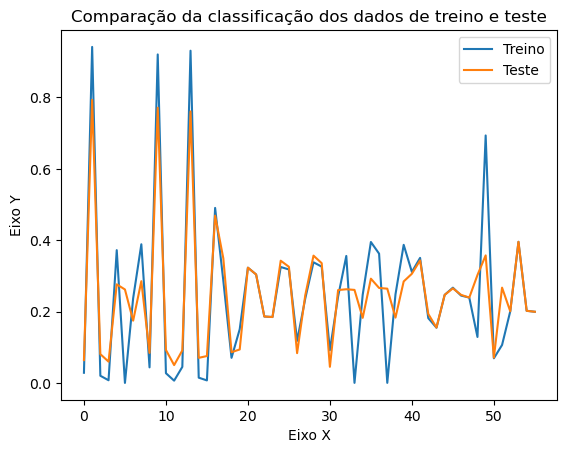

In [ ]:
import matplotlib.pyplot as plt

# Dados para as duas linhas
y1 = caract[2]  # Primeira linha
y2 = val[2]  # Segunda linha

# Plotando as duas linhas
plt.plot(y1, label='Treino')
plt.plot(y2, label='Teste')

# Adicionando rótulos aos eixos e título ao gráfico
plt.xlabel('Eixo X')
plt.ylabel('Eixo Y')
plt.title('Comparação da classificação dos dados de treino e teste')

# Adicionando legenda
plt.legend()

# Exibindo o gráfico
plt.show()



### Treino em loop de todas as opções de classificadores disponiveis no Select Model.

In [ ]:
algos = ['1nn', '3nn', 'svm', 'nb', 'gbc', 'rf', 'rd']
for algo in algos:
    
    print(f'Meta-classificador com modelo extrator {algo.upper()}')
    
    # Training
    try:
        trained_base_models, meta_classifier = train_with_meta_classifier(X_train, y_train, base_option=algo, meta_option='rd')
        # Testing
        predictions_test_meta = predict_with_meta_classifier(X_test, trained_base_models, meta_classifier)
    
        test_accuracy_meta = np.mean(predictions_test_meta == y_test)
        print(f'Acurácia do teste usando o meta-classificador com modelo extrator {algo}: {test_accuracy_meta}')
    except Exception as e:
        print(f"Ocorreu um erro no teste com o {algo}: {e}")
    print("-------------------------------")

Meta-classificador com modelo extrator 1NN


Testing Instances: 100%|##########| 391/391 [00:05<00:00, 68.11it/s]


Acurácia do teste usando o meta-classificador com modelo extrator 1nn: 0.6061381074168798
-------------------------------
Meta-classificador com modelo extrator 3NN


Testing Instances: 100%|##########| 391/391 [00:06<00:00, 62.28it/s]


Acurácia do teste usando o meta-classificador com modelo extrator 3nn: 0.7468030690537084
-------------------------------
Meta-classificador com modelo extrator SVM


Testing Instances: 100%|##########| 391/391 [00:03<00:00, 106.55it/s]


Acurácia do teste usando o meta-classificador com modelo extrator svm: 0.8081841432225064
-------------------------------
Meta-classificador com modelo extrator NB


Testing Instances: 100%|##########| 391/391 [00:10<00:00, 36.28it/s]


Acurácia do teste usando o meta-classificador com modelo extrator nb: 0.6828644501278772
-------------------------------
Meta-classificador com modelo extrator GBC


Testing Instances: 100%|##########| 391/391 [00:11<00:00, 33.14it/s]


Acurácia do teste usando o meta-classificador com modelo extrator gbc: 0.6265984654731458
-------------------------------
Meta-classificador com modelo extrator RF


Testing Instances: 100%|##########| 391/391 [01:08<00:00,  5.68it/s]


Acurácia do teste usando o meta-classificador com modelo extrator rf: 0.7391304347826086
-------------------------------
Meta-classificador com modelo extrator RD


Training Base Models: 100%|##########| 14/14 [00:00<00:00, 26.18it/s]

Ocorreu um erro no teste com o rd: 'RidgeClassifierCV' object has no attribute 'predict_proba'
-------------------------------


### Treino em mega-loop com todos os datasets disponiveis no timeseriesclassification.

In [ ]:
algos = ['1nn']

# Para cada conjunto de dados na lista
total_time = 0
for dataset_name in univariate_equal_length:
    # Carregue os dados de treinamento e teste
    X_train, y_train = load_classification(dataset_name, extract_path="./Temp/", split="TRAIN")
    X_test, y_test = load_classification(dataset_name, extract_path="./Temp/", split="test")
    
    # Achatando os dados para 2D, pois alguns algoritmos esperam 2D
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    
    dataset_accuracies = []
    # Para cada algoritmo
    for algo in algos:
        # Treinar o modelo e fazer previsões
        start = timeit.default_timer()
        trained_base_models, meta_classifier = train_with_meta_classifier(X_train_flat, y_train, base_option='svm', meta_option='rd')
        predictions_test_meta = predict_with_meta_classifier(X_test_flat, trained_base_models, meta_classifier)
        stop = timeit.default_timer()
        total_time += stop - start
        real_time = str(timedelta(seconds=total_time))
        
        # Calcular a acurácia e armazená-la
        test_accuracy_meta = np.mean(predictions_test_meta == y_test)
        dataset_accuracies.append(test_accuracy_meta)
        
        
        print(f"Acurácia do modelo {algo} para {dataset_name}: {test_accuracy_meta}")
        print('Time runtime (seconds): ', real_time)
        
np.savetxt("Results_1NN_.csv", dataset_accuracies, delimiter=",")